In [163]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder


- separate 'price' into 'price_value' and 'currency'
- for simplicity, convert 'currency' with value usd to sgd at 1.35
- convert 'num_adults' and 'num_children' to numeric types
- drop one record with no target variable
- convert 'first_time' and 'no_show' to bool type

In [164]:
with sqlite3.connect('data/noshow.db') as conn:
    df = pd.read_sql('select * from noshow', conn)

df.describe()

,booking_id,no_show,arrival_day,checkout_day,num_children
count,119391.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,59695.000000,0.370416,15.798241,14.250507,0.871229
std,34465.357332,0.482918,8.780829,11.063697,0.779796
min,0.000000,0.000000,1.000000,-31.000000,0.000000
25%,29847.500000,0.000000,8.000000,7.000000,0.000000
50%,59695.000000,0.000000,16.000000,15.000000,1.000000
75%,89542.500000,1.000000,23.000000,23.000000,1.000000
max,119390.000000,1.000000,31.000000,31.000000,3.000000


In [165]:
df.head()

,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children
0,94113,0.0,Changi,November,June,25.0,June,27.0,Singapore,Yes,Single,SGD$ 492.98,Website,1,0.0
1,86543,0.0,Orchard,August,November,28.0,November,29.0,Indonesia,Yes,King,SGD$ 1351.22,Website,2,0.0
2,75928,0.0,Changi,March,February,7.0,February,11.0,India,Yes,Single,None,Agent,1,0.0
3,66947,1.0,Orchard,September,October,1.0,October,3.0,China,Yes,Single,SGD$ 666.04,Website,1,0.0
4,106390,0.0,Orchard,March,June,20.0,June,24.0,Australia,Yes,Queen,USD$ 665.37,Website,1,0.0


In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119391 entries, 0 to 119390
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   booking_id      119391 non-null  int64  
 1   no_show         119390 non-null  float64
 2   branch          119390 non-null  object 
 3   booking_month   119390 non-null  object 
 4   arrival_month   119390 non-null  object 
 5   arrival_day     119390 non-null  float64
 6   checkout_month  119390 non-null  object 
 7   checkout_day    119390 non-null  float64
 8   country         119390 non-null  object 
 9   first_time      119390 non-null  object 
 10  room            97778 non-null   object 
 11  price           94509 non-null   object 
 12  platform        119390 non-null  object 
 13  num_adults      119390 non-null  object 
 14  num_children    119390 non-null  float64
dtypes: float64(4), int64(1), object(10)
memory usage: 13.7+ MB


In [167]:
missing_percentage = (df.isnull().sum() / len(df)) * 100
print(missing_percentage)

booking_id         0.000000
no_show            0.000838
branch             0.000838
booking_month      0.000838
arrival_month      0.000838
arrival_day        0.000838
checkout_month     0.000838
checkout_day       0.000838
country            0.000838
first_time         0.000838
room              18.102705
price             20.840767
platform           0.000838
num_adults         0.000838
num_children       0.000838
dtype: float64


In [168]:
# remove 1 row without target output
df = df[df['no_show'].notna()]
df

,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children
0,94113,0.0,Changi,November,June,25.0,June,27.0,Singapore,Yes,Single,SGD$ 492.98,Website,1,0.0
1,86543,0.0,Orchard,August,November,28.0,November,29.0,Indonesia,Yes,King,SGD$ 1351.22,Website,2,0.0
2,75928,0.0,Changi,March,February,7.0,February,11.0,India,Yes,Single,None,Agent,1,0.0
3,66947,1.0,Orchard,September,October,1.0,October,3.0,China,Yes,Single,SGD$ 666.04,Website,1,0.0
4,106390,0.0,Orchard,March,June,20.0,June,24.0,Australia,Yes,Queen,USD$ 665.37,Website,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119386,4823,0.0,Changi,September,April,3.0,April,5.0,China,Yes,King,USD$ 612.18,Website,1,1.0
119387,25062,0.0,Orchard,March,December,30.0,January,3.0,China,Yes,King,USD$ 1041.29,Email,2,0.0
119388,81936,1.0,Changi,September,March,31.0,April,1.0,Indonesia,Yes,King,USD$ 641.47,Email,1,2.0
119389,6738,0.0,Changi,February,February,25.0,February,27.0,China,Yes,None,SGD$ 886.35,Website,2,0.0


In [169]:
missing_percentage = (df.isnull().sum() / len(df)) * 100
print(missing_percentage)

booking_id         0.000000
no_show            0.000000
branch             0.000000
booking_month      0.000000
arrival_month      0.000000
arrival_day        0.000000
checkout_month     0.000000
checkout_day       0.000000
country            0.000000
first_time         0.000000
room              18.102019
price             20.840104
platform           0.000000
num_adults         0.000000
num_children       0.000000
dtype: float64


In [170]:
df['num_adults'] = df['num_adults'].replace({'one': 1, 'two': 2}).astype(int)
df['num_children'] = df['num_children'].astype(int)
df

,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children
0,94113,0.0,Changi,November,June,25.0,June,27.0,Singapore,Yes,Single,SGD$ 492.98,Website,1,0
1,86543,0.0,Orchard,August,November,28.0,November,29.0,Indonesia,Yes,King,SGD$ 1351.22,Website,2,0
2,75928,0.0,Changi,March,February,7.0,February,11.0,India,Yes,Single,None,Agent,1,0
3,66947,1.0,Orchard,September,October,1.0,October,3.0,China,Yes,Single,SGD$ 666.04,Website,1,0
4,106390,0.0,Orchard,March,June,20.0,June,24.0,Australia,Yes,Queen,USD$ 665.37,Website,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119386,4823,0.0,Changi,September,April,3.0,April,5.0,China,Yes,King,USD$ 612.18,Website,1,1
119387,25062,0.0,Orchard,March,December,30.0,January,3.0,China,Yes,King,USD$ 1041.29,Email,2,0
119388,81936,1.0,Changi,September,March,31.0,April,1.0,Indonesia,Yes,King,USD$ 641.47,Email,1,2
119389,6738,0.0,Changi,February,February,25.0,February,27.0,China,Yes,None,SGD$ 886.35,Website,2,0


In [171]:
df['currency'] = df['price'].str.extract(r'([A-Z]+)')
df['price_value'] = df['price'].str.extract(r'([\d.]+)').astype(float)
df.drop(columns=['price'], inplace=True)

usd_to_sgd_rate = 1.35
df['price'] = df.apply(
    lambda row : row['price_value'] * usd_to_sgd_rate if row['currency'] == 'USD' else row['price_value'],
    axis=1)

df.drop(columns=['currency', 'price_value'], inplace=True)

In [172]:
df.dtypes


booking_id          int64
no_show           float64
branch             object
booking_month      object
arrival_month      object
arrival_day       float64
checkout_month     object
checkout_day      float64
country            object
first_time         object
room               object
platform           object
num_adults          int64
num_children        int64
price             float64
dtype: object

In [173]:
df['first_time'] = df['first_time'].map({'Yes': True, 'No': False}).astype(bool)
df['no_show'] = df['no_show'].astype(bool)

In [174]:
df

,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,platform,num_adults,num_children,price
0,94113,False,Changi,November,June,25.0,June,27.0,Singapore,True,Single,Website,1,0,492.9800
1,86543,False,Orchard,August,November,28.0,November,29.0,Indonesia,True,King,Website,2,0,1351.2200
2,75928,False,Changi,March,February,7.0,February,11.0,India,True,Single,Agent,1,0,NaN
3,66947,True,Orchard,September,October,1.0,October,3.0,China,True,Single,Website,1,0,666.0400
4,106390,False,Orchard,March,June,20.0,June,24.0,Australia,True,Queen,Website,1,0,898.2495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119386,4823,False,Changi,September,April,3.0,April,5.0,China,True,King,Website,1,1,826.4430
119387,25062,False,Orchard,March,December,30.0,January,3.0,China,True,King,Email,2,0,1405.7415
119388,81936,True,Changi,September,March,31.0,April,1.0,Indonesia,True,King,Email,1,2,865.9845
119389,6738,False,Changi,February,February,25.0,February,27.0,China,True,None,Website,2,0,886.3500


In [175]:
df.to_csv('data/processed_data.csv')

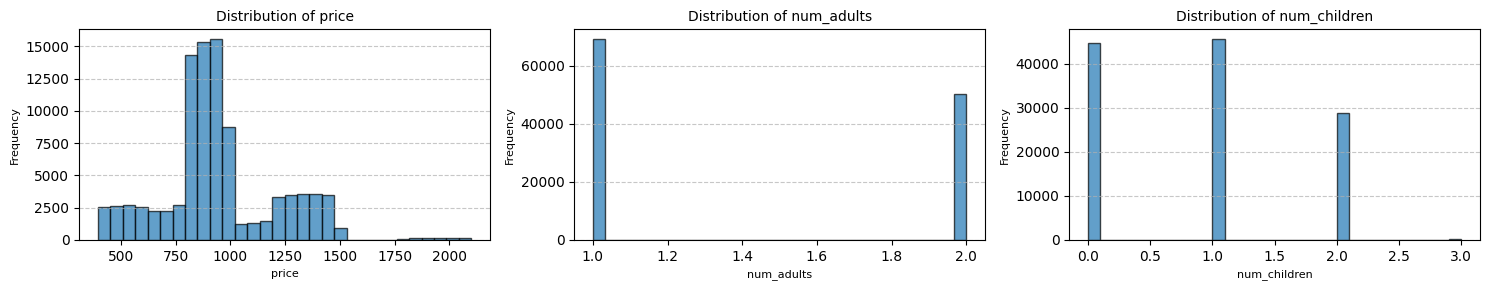

In [176]:
numerical_features = ['price', 'num_adults', 'num_children']

fig, axes = plt.subplots(1, 3, figsize=(15, 3)) 
axes = axes.flatten() 

for i, col in enumerate(numerical_features):
    if i < len(axes): 
        axes[i].hist(df[col].dropna(), bins=30, edgecolor='k', alpha=0.7)
        axes[i].set_title(f"Distribution of {col}", fontsize=10)
        axes[i].set_xlabel(col, fontsize=8)
        axes[i].set_ylabel("Frequency", fontsize=8)
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)

for j in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() 
plt.show()


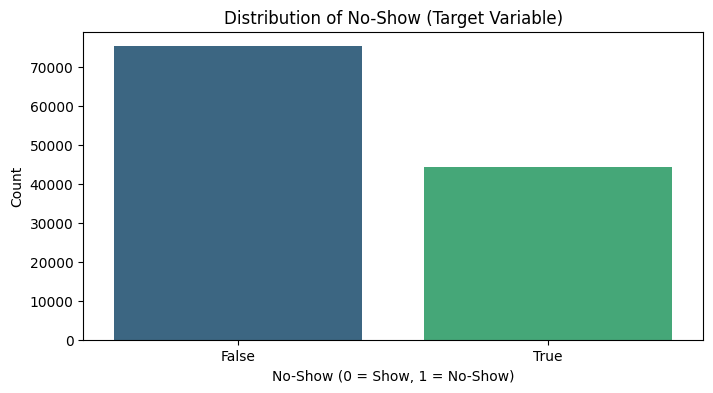

In [177]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x="no_show", hue="no_show", palette="viridis", legend=False)
plt.title("Distribution of No-Show (Target Variable)")
plt.xlabel("No-Show (0 = Show, 1 = No-Show)")
plt.ylabel("Count")
plt.show()